In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
# Open quatratically detrended ts data for the 20 CMIP6 models 
data = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_ts_quad_detrend_1900_2015.nc').chunk('auto')

In [ ]:
# Calculate anomalies 
clims = data.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = (data.groupby('time.month') - clims).chunk('auto')

In [ ]:
# Take DJF average
quarterly_anoms = anoms.resample(time='QS-DEC').mean('time')
djf_anoms = quarterly_anoms.isel(time=slice(0,None,4))

In [ ]:
# NINO indices 
EP = xr.open_dataarray('/g/data/w40/rl5183/EP_nino_cmip6_20.nc')
CP = xr.open_dataarray('/g/data/w40/rl5183/CP_nino_cmip6_20.nc')

In [ ]:
# Take DJF average of EP index and CP index
quarterly_EP = EP.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))

In [ ]:
# Linear regression of SST anomalies onto EP index and CP index
EP_regress_list = []
CP_regress_list = []
for m in djf_anoms.model:
    EP_regress_list.append(func.regress_nino(djf_anoms.sel(model=m).drop_sel(time='1899-12'), djf_EP.sel(model=m).drop_sel(time='1899-12')))
    CP_regress_list.append(func.regress_nino(djf_anoms.sel(model=m).drop_sel(time='1899-12'), djf_CP.sel(model=m).drop_sel(time='1899-12')))

In [ ]:
EP_regress_list

In [ ]:
EP_regressions = xr.concat(EP_regress_list, dim='model')
CP_regressions = xr.concat(CP_regress_list, dim='model')

In [ ]:
EP_regressions.to_netcdf('/g/data/w40/rl5183/CMIP6_20_EP_temp_regressions')
CP_regressions.to_netcdf('/g/data/w40/rl5183/CMIP6_20_CP_temp_regressions')

In [2]:
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_EP_temp_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_CP_temp_regressions')

In [ ]:
fig = plt.figure(figsize=(20,12.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(EP_regressions.model):
    # Flip pattern so positive regression in tropical pacific
    if EP_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        d = EP_regressions.sel(model=m)*-1
    else: d = EP_regressions.sel(model=m)
    # Plot 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

#plt.savefig('CMIP6_EP_glob_ts_pattern_NINO', bbox_inches='tight', dpi=300)

In [ ]:
fig = plt.figure(figsize=(20,12.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(CP_regressions.model):
    # Flip pattern so positive regression in tropical pacific
    if CP_regressions.sel(model=m).sel(lat=-0.75).sel(lon=222) < 0:
        d = CP_regressions.sel(model=m)*-1
    else: d = CP_regressions.sel(model=m)
    # Plot 
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

#plt.savefig('CMIP6_CP_glob_ts_pattern_NINO', bbox_inches='tight', dpi=300)

#### Pattern correlations

In [3]:
# Read in the quadratically detrended 20CR temp
temp = xr.open_dataarray('/g/data/w40/rl5183/20CR_tmp_ensemble_mean_quad_detrend_1.5x1.5.nc')
# Calculate anomalies
clim = temp.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (temp.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# NINO indices from Hadisst
sst = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc').sst
# Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate EP and CP index
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = (nino3 - 0.5*nino4).sel(time=slice('1900-01', '2014-12'))
CP_sst = (nino4 - 0.5*nino3).sel(time=slice('1900-01', '2014-12'))
# Take DJF average of EP index and CP index
quarterly_EP = EP_sst.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP_sst.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [4]:
def group_by_lat(data, regions):
    data_by_lat = []
    for reg_name,reg_loc in regions.items():
        data_sliced = data.sel(lat=reg_loc).rename(reg_name)
        data_by_lat.append(data_sliced)
    data_by_lat = xr.merge(data_by_lat)
    return data_by_lat

In [5]:
# Define the regions
regions = {
    "Tropics":slice(-23.5,23.5),
    "Subtropics_NH":slice(23.5,35.5),
    "Subtropics_SH":slice(-35.5, -23.5),
    "Mid_latitudes_NH":slice(35.5, 66.5),
    "Mid_latitudes_SH":slice(-66.5, -35.5),
}

In [6]:
EP_grouped_20CR = group_by_lat(EP_regress_20CR, regions)
CP_grouped_20CR = group_by_lat(CP_regress_20CR, regions)

In [7]:
EP_grouped = []
for m in EP_regressions.model:
    EP_grouped.append(group_by_lat(EP_regressions.sel(model=m), regions))
EP_grouped = xr.concat(EP_grouped, dim='model')

In [8]:
CP_grouped = []
for m in CP_regressions.model:
    CP_grouped.append(group_by_lat(CP_regressions.sel(model=m), regions))
CP_grouped = xr.concat(CP_grouped, dim='model')

In [9]:
Tropics_cor_EP = []
for m in EP_grouped.model:
    Tropics_cor_EP.append(func.pattern_cor(EP_grouped.Tropics.sel(model=m), EP_grouped_20CR.Tropics))
    
Sub_NH_cor_EP = []
for m in EP_grouped.model:
    Sub_NH_cor_EP.append(func.pattern_cor(EP_grouped.Subtropics_NH.sel(model=m), EP_grouped_20CR.Subtropics_NH))
    
Sub_SH_cor_EP = []
for m in EP_grouped.model:
    Sub_SH_cor_EP.append(func.pattern_cor(EP_grouped.Subtropics_SH.sel(model=m), EP_grouped_20CR.Subtropics_SH))
    
Mid_NH_cor_EP = []
for m in EP_grouped.model:
    Mid_NH_cor_EP.append(func.pattern_cor(EP_grouped.Mid_latitudes_NH.sel(model=m), EP_grouped_20CR.Mid_latitudes_NH))
    
Mid_SH_cor_EP = []
for m in EP_grouped.model:
    Mid_SH_cor_EP.append(func.pattern_cor(EP_grouped.Mid_latitudes_SH.sel(model=m), EP_grouped_20CR.Mid_latitudes_SH))

In [10]:
Tropics_cor_CP = []
for m in CP_grouped.model:
    Tropics_cor_CP.append(func.pattern_cor(CP_grouped.Tropics.sel(model=m), CP_grouped_20CR.Tropics))
    
Sub_NH_cor_CP = []
for m in CP_grouped.model:
    Sub_NH_cor_CP.append(func.pattern_cor(CP_grouped.Subtropics_NH.sel(model=m), CP_grouped_20CR.Subtropics_NH))
    
Sub_SH_cor_CP = []
for m in CP_grouped.model:
    Sub_SH_cor_CP.append(func.pattern_cor(CP_grouped.Subtropics_SH.sel(model=m), CP_grouped_20CR.Subtropics_SH))
    
Mid_NH_cor_CP = []
for m in CP_grouped.model:
    Mid_NH_cor_CP.append(func.pattern_cor(CP_grouped.Mid_latitudes_NH.sel(model=m), CP_grouped_20CR.Mid_latitudes_NH))
    
Mid_SH_cor_CP = []
for m in CP_grouped.model:
    Mid_SH_cor_CP.append(func.pattern_cor(CP_grouped.Mid_latitudes_SH.sel(model=m), CP_grouped_20CR.Mid_latitudes_SH))

In [11]:
# Make pandas dataframe 
model_names = EP_regressions.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], Tropics_cor_EP[i], Sub_NH_cor_EP[i], Sub_SH_cor_EP[i], Mid_NH_cor_EP[i], Mid_SH_cor_EP[i]]
    pandas_data.append(cell)
    
EP_df = pd.DataFrame(pandas_data, columns=['Model', 'Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'])
EP_df.head()

,Model,Tropics,Sub Tropics NH,Sub Tropics SH,Mid Lats NH,Mid Lats SH
0,ACCESS-CM2,0.866310,0.640019,0.799055,0.624892,0.675516
1,ACCESS-ESM1-5,0.830907,0.614958,0.750971,0.093454,0.688102
2,BCC-CSM2-MR,0.803712,0.665860,0.783506,0.280143,0.620280
3,CanESM5,0.662054,0.641007,0.846153,0.365979,0.616774
4,EC-Earth3,0.901118,0.483141,0.798873,0.062349,0.635457


In [ ]:
EP_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('EP TEMP NINO')

In [ ]:
EP_df.boxplot(column=['Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'], figsize=(7.5,5))
plt.title('EP TEMP NINO')

In [12]:
# Make pandas dataframe 
model_names = CP_regressions.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], Tropics_cor_CP[i], Sub_NH_cor_CP[i], Sub_SH_cor_CP[i], Mid_NH_cor_CP[i], Mid_SH_cor_CP[i]]
    pandas_data.append(cell)
    
CP_df = pd.DataFrame(pandas_data, columns=['Model', 'Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'])
CP_df.head()

,Model,Tropics,Sub Tropics NH,Sub Tropics SH,Mid Lats NH,Mid Lats SH
0,ACCESS-CM2,0.846656,0.789074,0.803481,0.603352,0.886146
1,ACCESS-ESM1-5,0.688373,0.542004,0.798762,0.489894,0.812768
2,BCC-CSM2-MR,0.775853,0.715708,0.791336,0.597223,0.824637
3,CanESM5,0.632032,0.783904,0.848268,0.592449,0.654291
4,EC-Earth3,0.796247,0.440992,0.781122,0.079610,0.834197


In [13]:
%store EP_df
%store CP_df

Stored 'EP_df' (DataFrame)
Stored 'CP_df' (DataFrame)


In [ ]:
CP_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('CP TEMP NINO')

In [ ]:
CP_df.boxplot(column=['Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'], figsize=(7.5,5))
plt.title('CP TEMP NINO')

Text(0, 0.5, 'CP')

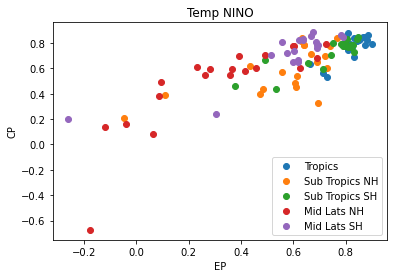

In [13]:
plt.scatter(EP_df['Tropics'], CP_df['Tropics'], label='Tropics')
plt.scatter(EP_df['Sub Tropics NH'], CP_df['Sub Tropics NH'], label='Sub Tropics NH')
plt.scatter(EP_df['Sub Tropics SH'], CP_df['Sub Tropics SH'], label='Sub Tropics SH')
plt.scatter(EP_df['Mid Lats NH'], CP_df['Mid Lats NH'], label='Mid Lats NH')
plt.scatter(EP_df['Mid Lats SH'], CP_df['Mid Lats SH'], label='Mid Lats SH')
plt.title('Temp NINO')
plt.legend()
plt.xlabel('EP')
plt.ylabel('CP')

In [ ]:
%store -r had_EP_sst_nino

In [ ]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(2,3,1)
ax.scatter(had_EP_sst_nino, Tropics_cor_EP)
ax.title.set_text('Tropics')
ax = fig.add_subplot(2,3,2)
ax.scatter(had_EP_sst_nino, Sub_NH_cor_EP)
ax.title.set_text('Sub tropics NH')
ax = fig.add_subplot(2,3,3)
ax.scatter(had_EP_sst_nino, Sub_SH_cor_EP)
ax.title.set_text('Sub tropics SH')
ax = fig.add_subplot(2,3,4)
ax.scatter(had_EP_sst_nino, Mid_NH_cor_EP)
ax.title.set_text('Mid lats NH')
ax = fig.add_subplot(2,3,5)
ax.scatter(had_EP_sst_nino, Mid_SH_cor_EP)
ax.title.set_text('Mid lats SH')

In [ ]:
%store -r had_CP_sst_nino

In [ ]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(2,3,1)
ax.scatter(had_CP_sst_nino, Tropics_cor_CP)
ax.title.set_text('Tropics')
ax = fig.add_subplot(2,3,2)
ax.scatter(had_CP_sst_nino, Sub_NH_cor_CP)
ax.title.set_text('Sub tropics NH')
ax = fig.add_subplot(2,3,3)
ax.scatter(had_CP_sst_nino, Sub_SH_cor_CP)
ax.title.set_text('Sub tropics SH')
ax = fig.add_subplot(2,3,4)
ax.scatter(had_CP_sst_nino, Mid_NH_cor_CP)
ax.title.set_text('Mid lats NH')
ax = fig.add_subplot(2,3,5)
ax.scatter(had_CP_sst_nino, Mid_SH_cor_CP)
ax.title.set_text('Mid lats SH')

#### Do models with better temp teleconnection also have better precip teleconnection? 

In [13]:
EP_temp = EP_df.copy()
CP_temp = CP_df.copy()

In [14]:
%store EP_temp
%store CP_temp

Stored 'EP_temp' (DataFrame)
Stored 'CP_temp' (DataFrame)
